In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
import os
os.chdir("/content/gdrive/My Drive/682")
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import random_split
from classifier import Classifier
import numpy as np
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import pdb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/gdrive


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(227),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
    ])

ds = datasets.ImageFolder(
        root = 'images/',
        transform = train_transform,
        )
ds_train, ds_val, ds_test = random_split(ds, [0.7, 0.15, 0.15])

train_loader = torch.utils.data.DataLoader(
        dataset=ds_train,
        batch_size=64,
        shuffle=True,
        num_workers=1)
val_loader = torch.utils.data.DataLoader(
        dataset=ds_val,
        batch_size=64,
        shuffle=False,
        num_workers=1)

In [ ]:
num_classes = len(ds.classes)
print(f'number of classes: {num_classes}')

number of classes: 12


In [ ]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    losses_plot = []
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
        losses_plot.append(loss.detach().item())

    return torch.stack(losses).mean().item(), losses_plot

def test_classifier(test_loader, classifier, criterion, print_ind_classes=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0))
        y_score = np.zeros((0,num_classes))
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss.item())
        aps = []

        B = y_true.shape[0]
        y_true_one_hot = np.zeros((B, num_classes))
        y_true_one_hot[np.arange(B), y_true.astype(np.int16)] = 1

        for i in range(num_classes):
            ap = average_precision_score(y_true_one_hot[:, i], y_score[:, i])
            if print_ind_classes:
                print(f'-------  Class: {i}     AP: {ap:>8.4f}  -------')
            aps.append(ap)

        mAP = np.mean(aps)
        test_loss = np.mean(losses)
        print('mAP: {0:.4f}'.format(mAP))
        print('Avg loss: {}'.format(test_loss))

    return mAP, test_loss, aps

In [ ]:
# plot functions
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def plot_mAP(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("mAP Plot")
    plt.ylabel("mAP")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [ ]:
classifier = Classifier(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 20
test_frequency = 5

train_losses = []
train_mAPs = []
val_losses = []
val_mAPs = []

for epoch in range(1, num_epochs+1):
    print("Starting epoch number " + str(epoch))
    train_loss, losses = train_classifier(train_loader, classifier, criterion, optimizer)
    train_losses.append(train_loss)
    print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
    if(epoch%test_frequency==0 or epoch==1):
        mAP_train, _, _ = test_classifier(train_loader, classifier, criterion)
        mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
        train_mAPs.append(mAP_train)
        print('Evaluating classifier')
        print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))
        val_losses.append(val_loss)
        val_mAPs.append(mAP_val)

test_loader = torch.utils.data.DataLoader(
        dataset=ds_test,
        batch_size=64,
        shuffle=False,
        num_workers=1)

mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Starting epoch number 1
Loss for Training on Epoch 1 is 2.553697109222412
-------  Class: 0     AP:   0.1740  -------
-------  Class: 1     AP:   0.1930  -------
-------  Class: 2     AP:   0.1321  -------
-------  Class: 3     AP:   0.2350  -------
-------  Class: 4     AP:   0.2205  -------
-------  Class: 5     AP:   0.0599  -------
-------  Class: 6     AP:   0.0957  -------
-------  Class: 7     AP:   0.5653  -------
-------  Class: 8     AP:   0.0568  -------
-------  Class: 9     AP:   0.3348  -------
-------  Class: 10     AP:   0.1043  -------
-------  Class: 11     AP:   0.0268  -------
mAP: 0.1832
Avg loss: 2.3289475440979004
-------  Class: 0     AP:   0.0517  -------
-------  Class: 1     AP:   0.5345  -------
-------  Class: 2     AP:   0.2544  -------
-------  Class: 3     AP:   0.1965  -------
-------  Class: 4     AP:   0.0769  -------
-------  Class: 5     AP:   0.0244  -------
-------  Class: 6     AP:   0.1190  -------
-------  Class: 7     AP:   0.3843  -------
---

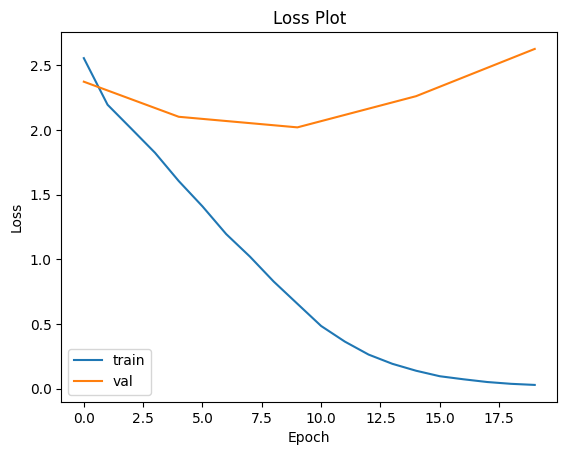

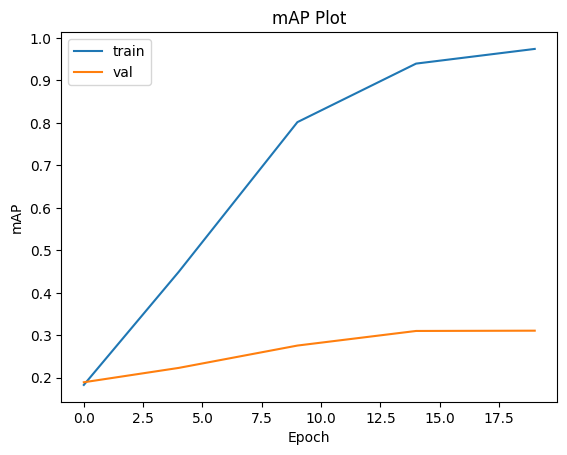

In [ ]:
plot_losses(train_losses, val_losses, test_frequency, num_epochs)
plot_mAP(train_mAPs, val_mAPs, test_frequency, num_epochs)

In [ ]:
num_epochs = 20
test_frequency = 5

# Load Pretrained ResNet
classifier = torchvision.models.resnet152(pretrained=True)
criterion = nn.CrossEntropyLoss()
num_feats = classifier.fc.in_features
classifier.fc = nn.Linear(num_feats, num_classes)
classifier = classifier.to(device)
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)

train_losses = []
train_mAPs = []
val_losses = []
val_mAPs = []

for epoch in range(1, num_epochs+1):
    print("Starting epoch number " + str(epoch))
    train_loss, losses = train_classifier(train_loader, classifier, criterion, optimizer)
    train_losses.append(train_loss)
    print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
    if(epoch%test_frequency==0 or epoch==1):
        mAP_train, _, _ = test_classifier(train_loader, classifier, criterion)
        mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
        train_mAPs.append(mAP_train)
        print('Evaluating classifier')
        print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))
        val_losses.append(val_loss)
        val_mAPs.append(mAP_val)

test_loader = torch.utils.data.DataLoader(
        dataset=ds_test,
        batch_size=64,
        shuffle=False,
        num_workers=1)

mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)

Starting epoch number 1
Loss for Training on Epoch 1 is 2.3883395195007324
-------  Class: 0     AP:   0.4241  -------
-------  Class: 1     AP:   0.2207  -------
-------  Class: 2     AP:   0.6222  -------
-------  Class: 3     AP:   0.7382  -------
-------  Class: 4     AP:   0.0378  -------
-------  Class: 5     AP:   0.4975  -------
-------  Class: 6     AP:   0.1416  -------
-------  Class: 7     AP:   0.6408  -------
-------  Class: 8     AP:   0.1618  -------
-------  Class: 9     AP:   0.6935  -------
-------  Class: 10     AP:   0.0765  -------
-------  Class: 11     AP:   0.0361  -------
mAP: 0.3576
Avg loss: 2.0596146881580353
-------  Class: 0     AP:   0.1521  -------
-------  Class: 1     AP:   0.3515  -------
-------  Class: 2     AP:   0.2000  -------
-------  Class: 3     AP:   0.5110  -------
-------  Class: 4     AP:   0.0294  -------
-------  Class: 5     AP:   0.1429  -------
-------  Class: 6     AP:   0.1637  -------
-------  Class: 7     AP:   0.8047  -------
--

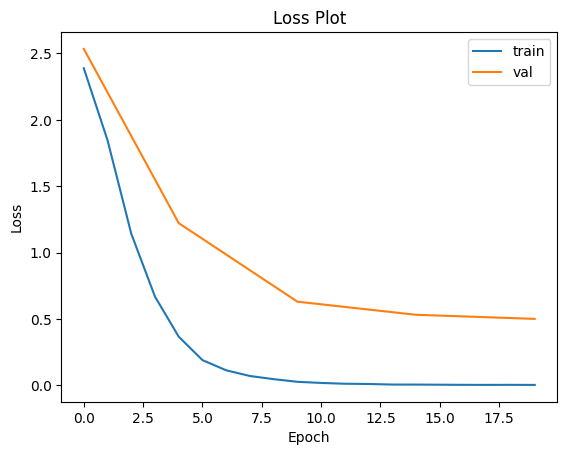

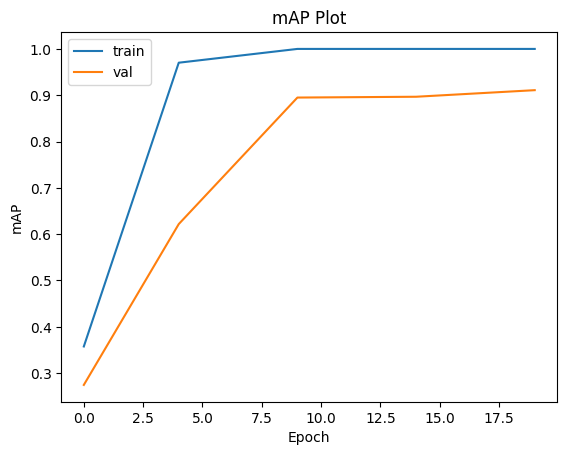

In [ ]:
plot_losses(train_losses, val_losses, test_frequency, num_epochs)
plot_mAP(train_mAPs, val_mAPs, test_frequency, num_epochs)

In [ ]:
print(train_losses)
print(val_losses)
print(train_mAPs)
print(val_mAPs)

[2.3883395195007324, 1.8453195095062256, 1.1411776542663574, 0.6669862270355225, 0.3654707074165344, 0.18905776739120483, 0.11237980425357819, 0.06942327320575714, 0.04563141614198685, 0.025707392022013664, 0.01719798892736435, 0.011139746755361557, 0.009278720244765282, 0.00503687746822834, 0.004682481754571199, 0.003845508210361004, 0.002817425411194563, 0.0024415813386440277, 0.0028014229610562325, 0.0022181691601872444]
[2.5341315269470215, 1.2212913036346436, 0.6295450925827026, 0.5307191014289856, 0.49986734986305237]
[0.35756414925906294, 0.9702421920185079, 1.0, 1.0, 1.0]
[0.27453568561598657, 0.6218086893465681, 0.8949891774891775, 0.8967393985942373, 0.9109411075036076]
